# Using Neural Networks to determine O/H from strong lines

## Following the paper of Marino et al 2013, artificial neural networks is used to compute a fit to the observed relation between some strong lines and the oxygen abundance.

## The ANN is defined, trained and used with the help of the AI4neb library https://github.com/Morisset/AI4neb

***

### First import some useful libraries.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymysql
%matplotlib inline
dir_CSVs = 'CSVs/'

### Import the AI4neb library. If not installed, install it.

In [2]:
try:
    import ai4neb
except:
    !pip install -U git+https://github.com/morisset/AI4neb.git
    import ai4neb
print(ai4neb.__version__)

0.2.9


### Import Ho ANN (using fork version to allow installation. EDIT: the Ho version merged the Morisset version)

In [3]:
try:
    from OxygenMLP import OxygenMLP
except:
    !pip install -U git+https://github.com/morisset/OxygenMLP.git
    from OxygenMLP import OxygenMLP

  Cloning https://github.com/morisset/OxygenMLP.git to /private/var/folders/7b/7gktm_g91hn54p3gxj15kb1m0000gn/T/pip-req-build-ajcgcoh6
  Running command git clone -q https://github.com/morisset/OxygenMLP.git /private/var/folders/7b/7gktm_g91hn54p3gxj15kb1m0000gn/T/pip-req-build-ajcgcoh6
  Created wheel for OxygenMLP: filename=OxygenMLP-0.2.1-py3-none-any.whl size=202189 sha256=68c56c7a1aba56bf9da4c8591ce93622a9849f6a2d8c9722e185b2949aaf0220
  Stored in directory: /private/var/folders/7b/7gktm_g91hn54p3gxj15kb1m0000gn/T/pip-ephem-wheel-cache-thtagzku/wheels/04/4e/02/e865ca05cdf993cda9cd9b2f24ad6fb7edbb5e73626db8dc8d
Successfully built OxygenMLP


### We are using the Marino observed data and its O/H determination from strong line.

In [4]:
t = pd.read_csv(dir_CSVs + 'catalog_M13+err.csv', comment='#', names=('O2', 'eO2', 'Hb', 'eHb', 'O3', 'eO3', 'Ha', 'eHa', 'N2', 
                                                           'eN2', 'S217', 'eS217', 'S231', 'eS231', 'Ab(O)'))

In [5]:
t[0:5]

,O2,eO2,Hb,eHb,O3,eO3,Ha,eHa,N2,eN2,S217,eS217,S231,eS231,Ab(O)
0,1.25893,0.18884,1.0,0.15,0.12080,0.01812,2.87,0.4305,1.11702,0.16755,0.27615,0.04142,0.18410,0.02762,8.561
1,1.29122,0.19368,1.0,0.15,0.33194,0.04979,2.87,0.4305,1.19691,0.17954,0.24612,0.03692,0.16408,0.02461,8.661
2,1.15080,0.17262,1.0,0.15,0.41406,0.06211,2.87,0.4305,1.21636,0.18245,0.37770,0.05665,0.25180,0.03777,8.530
3,0.77983,0.11697,1.0,0.15,0.18970,0.02846,2.87,0.4305,1.16697,0.17505,0.24612,0.03692,0.16408,0.02461,8.634
4,0.62950,0.09442,1.0,0.15,0.06578,0.00987,2.87,0.4305,0.99784,0.14968,0.27615,0.04142,0.18410,0.02762,8.669


In [6]:
# Define some additional columns
t['R2+'] = t['O2']
t['N2+'] = t['N2'] * 1.34
t['S2+'] = t['S217'] + t['S231'] 
t['R3+'] = t['O3'] * 1.335
t['R23'] = t['R2+'] + t['R3+']
t['P'] = t['R3+'] / t['R23']
# Marino
t['N2/Ha'] = t['N2'] / t['Ha']
t['O3N2'] = t['O3']/t['N2/Ha']
t['log O3N2'] = np.log10(t['O3N2'])
t['log N2/Ha'] = np.log10(t['N2/Ha'])

/Users/christophemorisset/opt/miniconda3/envs/ML/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
# Let's clean the data from the NaN
t['log O3N2'][np.isinf(t['log O3N2'])] = np.nan
t = t.dropna()
print(len(t))

593


### Read Ho data

In [8]:
if False:
    t = pd.read_csv('Ho19_data.dat', comment='#', names=('O2', 'O3', 'N2', 'S2', 'Ab(O)', 'ref'), delimiter='   ')
    # Define some additional columns
    t['R2+'] = t['O2']
    t['N2+'] = t['N2'] * 1.34
    t['S2+'] = t['S2'] 
    t['R3+'] = t['O3'] * 1.335
    t['R23'] = t['R2+'] + t['R3+']
    t['P'] = t['R3+'] / t['R23']
    # Marino
    t['N2/Ha'] = t['N2'] / 2.85
    t['O3N2'] = t['O3']/t['N2/Ha']
    t['log O3N2'] = np.log10(t['O3N2'])
    t['log N2/Ha'] = np.log10(t['N2/Ha'])
    # Let's clean the data from the NaN
    t['log O3N2'][np.isinf(t['log O3N2'])] = np.nan
    t = t.dropna()
    print(t[0:5])
    print(len(t))

### Define some functions for the Marino's and Pyliugin's indicators

In [9]:
def ab_O3N2(O3N2):
    """ O3N2 = O3/Hb / (N2/Ha)"""
    return 8.533 - 0.214 * O3N2
def ab_N2(N2a):
    """ N2a = N2/Ha"""
    return 8.743 + 0.462 * N2a
def ab_P(R23, P):
    """ R23 = O2_3727+ + O3_5007+ """
    return (R23 + 54.2 + 59.45*P + 7.31*P**2) / (6.07 + 6.71*P + 0.371 * P**2 + 0.243 * R23)
def ab_P16(R2p, R3p, N2p):
    mask = np.log10(N2p) >= -0.6
    res = np.empty_like(R2p)
    res[mask] = (8.598 + 0.022 * np.log10(R3p/R2p) + 0.399 * np.log10(N2p) + 
                (-0.137 + 0.164 * np.log10(R3p/R2p) + 0.589 * np.log10(N2p)) * np.log10(R2p))[mask]
    res[~mask] = (7.932 + 0.944 * np.log10(R3p/R2p) + 0.695 * np.log10(N2p) + 
                (0.970 - 0.291 * np.log10(R3p/R2p) - 0.019 * np.log10(N2p)) * np.log10(R2p))[~mask]
    return res

### Define some color codes

In [10]:
c_TF = 'b'
c_SK = 'orange'
c_Marino = 'r'

### Define a seed for the random number generators

In [11]:
random_seed = 10 #6

### The data are plotted like in Fig. 2 of Marino et al. 2013

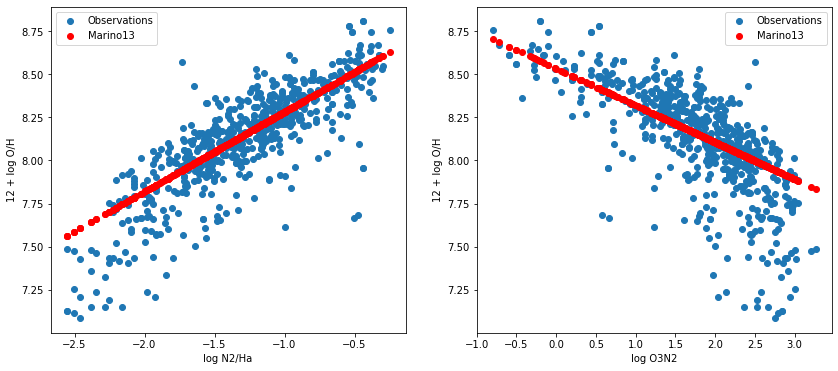

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
diag = 'log N2/Ha'
ax1.scatter(t[diag], t['Ab(O)'], label='Observations')
ax1.scatter(t[diag], ab_N2(t[diag]), c=c_Marino, label='Marino13')
ax1.set_xlabel(diag)
ax1.set_ylabel('12 + log O/H')
ax1.legend()
diag = 'log O3N2'
ax2.scatter(t[diag], t['Ab(O)'], label='Observations')
ax2.scatter(t[diag], ab_O3N2(t[diag]), c=c_Marino, label='Marino13')
ax2.set_xlabel(diag)
ax2.set_ylabel('12 + log O/H')
ax2.legend();

### A Regression Model object is instantiated. Some parameters already appear here: 
- ### 'ANN' from Scikit is used.
- ### X_train and y_train sets are from the Marino's data.
- ### The X data are scaled in a preprocessing step.
- ### A random_seed is set to be able to obtain the same result in various run.

In [13]:
RM1 = ai4neb.manage_RM(RM_type='SK_ANN', 
                       X_train=t[diag], 
                       y_train=t['Ab(O)'],
                       scaling=True, 
                       verbose=True, 
                       random_seed=random_seed)

Instantiation. V 0.17
Training set size = 593, Test set size = 0
Train data scaled. 
Test data scaled. 
Training set size = 593, Test set size = 0
Training set size = 593, Test set size = 0


### The artificial neural network is defined by seting some parameters:
- ### The structure of the NN is defined by the number neurons in each hidden layer.
- ### A tolerance is given for the convergence process to stop.
- ### A maximum number of iteration is givento stop the convergence process if not reaching the tolerance limit.
- ### The activation function of all the cells in the NN is given.
- ### The solver for the convergence is given.

In [14]:
RM1.init_RM(hidden_layer_sizes=(30,10), 
            tol=1e-7, 
            max_iter=10000, 
            activation='tanh',
            solver='adam')

Regression Model SK_ANN


### The model is now trained. That may take a while, depending on the size of the network and the number of iterations.
### As we set the verbosity to True, some output appears.

In [15]:
RM1.train_RM()

Training 1 inputs for 1 outputs with 593 data
RM trained, with 2140 iterations. Score = 0.545
MLPRegressor(activation='tanh', hidden_layer_sizes=(30, 10), max_iter=10000,
             random_state=10, tol=1e-07)
Training time 6.8 s.


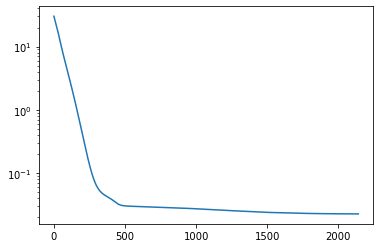

In [16]:
f, ax = plt.subplots()
RM1.plot_loss(ax=ax)

### Define the X data set on which the regression will be tested. 
### Minimum and maximum values of Marino data set are used.

In [17]:
X_test = np.linspace(np.min(t[diag]), np.max(t[diag]), 500)
X_test = t[diag]

### Enter the X_test values to the object. Do not forget to scale them, using the same scaling than for the training data.

In [18]:
RM1.set_test(X_test)

Test data scaled. 
Training set size = 593, Test set size = 593


### The network makes the predictions corresponding to the X_test data set. The result of the prediction is stored in the RM object.

In [19]:
RM1.predict()

Predicting from 1 inputs to 1 outputs using 593 data in 0.00 secs.


### Draw the plot comparing the training set and the prediction.

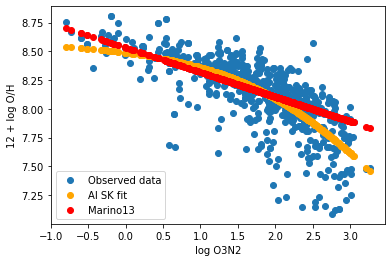

In [20]:
f, ax = plt.subplots()
ax.scatter(t[diag], t['Ab(O)'], label='Observed data')
ax.scatter(X_test, RM1.pred, c=c_SK, label='AI SK fit')
ax.scatter(X_test, ab_O3N2(X_test), c=c_Marino, label='Marino13')
ax.set_xlabel(diag)
ax.set_ylabel('12 + log O/H')
ax.legend();

### The same process is repeated, but this time with the N2 as metallicity diagnostic. The resulting object is stored in RM2.

Instantiation. V 0.17
Training set size = 593, Test set size = 593
Train data scaled. 
Test data scaled. 
Training set size = 593, Test set size = 593
Training set size = 593, Test set size = 593
Regression Model SK_ANN
Training 1 inputs for 1 outputs with 593 data
RM trained, with 90 iterations. Score = 0.708
MLPRegressor(activation='tanh', hidden_layer_sizes=(30, 10), max_iter=10000,
             random_state=10, solver='lbfgs', tol=1e-07)
Training time 0.2 s.
Predicting from 1 inputs to 1 outputs using 593 data in 0.00 secs.


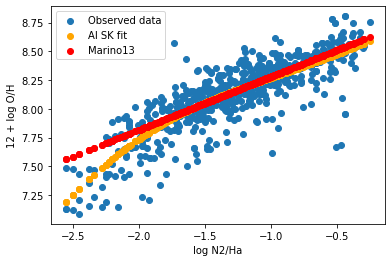

In [21]:
diag = 'log N2/Ha'
X_test = np.linspace(np.min(t[diag]), np.max(t[diag]), 500)
X_test = t[diag]
RM2 = ai4neb.manage_RM(RM_type='SK_ANN', 
                  X_train=t[diag], 
                  y_train=t['Ab(O)'], 
                  X_test=X_test,
                  scaling=True,
                  verbose=True, 
                  random_seed=random_seed)
RM2.init_RM(hidden_layer_sizes=(30,10), 
           tol=1e-7, 
           max_iter=10000, 
           activation='tanh',
           solver='lbfgs')
RM2.train_RM()
RM2.predict()
f, ax = plt.subplots()
ax.scatter(t[diag], t['Ab(O)'], label='Observed data')
ax.scatter(X_test, RM2.pred, c=c_SK, label='AI SK fit')
ax.scatter(X_test, ab_N2(X_test), c=c_Marino, label='Marino13')
ax.set_xlabel(diag)
ax.set_ylabel('12 + log O/H')
ax.legend(); #Score 0.708

### Change the library to the Keras/Tensorflow one. Only a few parameters need to be updated (namely: epochs in the init method)
### The plot compares the Scikit and Tensorflow results.

In [22]:
diag = 'log O3N2'
X_test = np.linspace(np.min(t[diag]), np.max(t[diag]), 500)
X_test = t[diag]
RM3 = ai4neb.manage_RM(RM_type='K_ANN',
                  X_train=t[diag], 
                  y_train=t['Ab(O)'], 
                  X_test=X_test,
                  scaling=True, 
                  verbose=True, 
                  random_seed=random_seed)
RM3.init_RM(hidden_layer_sizes=(30,20), dropout=(0., 0.3), 
           activation='tanh',
           solver='adam', 
           epochs=1600)
RM3.train_RM()
RM3.predict()

Instantiation. V 0.17
Training set size = 593, Test set size = 593
Train data scaled. 
Test data scaled. 
Training set size = 593, Test set size = 593
Training set size = 593, Test set size = 593
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________
Regression Model K_ANN
Training 1 inputs for 1 outputs with 

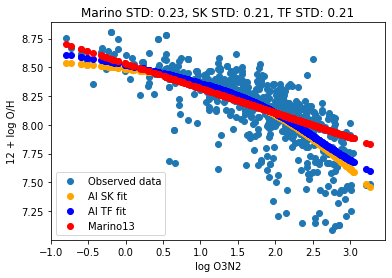

In [23]:
f, ax = plt.subplots()
ax.scatter(t[diag], t['Ab(O)'], label='Observed data')
ax.scatter(X_test, RM1.pred, c=c_SK, label='AI SK fit')
ax.scatter(X_test, RM3.pred, c=c_TF, label='AI TF fit')
ax.scatter(X_test, ab_O3N2(X_test), c=c_Marino, label='Marino13')
ax.set_xlabel(diag)
ax.set_ylabel('12 + log O/H')
ax.legend()
ax.set_title('Marino STD: {:.2f}, SK STD: {:.2f}, TF STD: {:.2f}'.format(np.std(ab_O3N2(X_test)-t['Ab(O)']), 
                                                                  np.std(RM1.pred.ravel()-t['Ab(O)']),
                                                                  np.std(RM3.pred.ravel()-t['Ab(O)'])));

#### Take care that the differences between the 2 libraries shown here may be dominated by the values of the hyper parameters used for each library, and do not reflect the capacity of the library to fit the data.

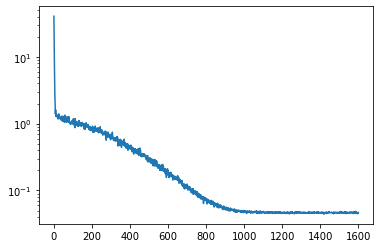

In [24]:
f, ax = plt.subplots()
RM3.plot_loss(ax=ax)

### The same comparison is performed for the N2 diagnostic.

Instantiation. V 0.17
Training set size = 593, Test set size = 593
Train data scaled. 
Test data scaled. 
Training set size = 593, Test set size = 593
Training set size = 593, Test set size = 593
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 30)                60        
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________
Regression Model K_ANN
Training 1 inputs for 1 outputs wit

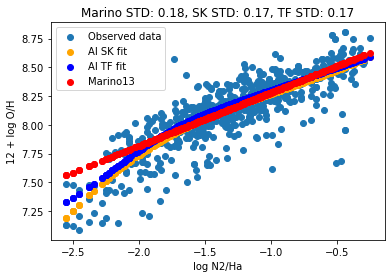

In [25]:
diag = 'log N2/Ha'
X_test = np.linspace(np.min(t[diag]), np.max(t[diag]), 500)
X_test = t[diag]
RM4 = ai4neb.manage_RM(RM_type='K_ANN',
                  X_train=t[diag], 
                  y_train=t['Ab(O)'], 
                  X_test=X_test,
                  scaling=True, 
                  verbose=True, 
                  random_seed=random_seed)
RM4.init_RM(hidden_layer_sizes=(30,20), dropout=(0., 0.3), 
           activation='tanh',
           solver='adam', 
           epochs=1600)
RM4.train_RM()
RM4.predict()
f, ax = plt.subplots()
ax.scatter(t[diag], t['Ab(O)'], label='Observed data')
ax.scatter(X_test, RM2.pred, c=c_SK, label='AI SK fit')
ax.scatter(X_test, RM4.pred, c=c_TF, label='AI TF fit')
ax.scatter(X_test, ab_N2(X_test), c=c_Marino, label='Marino13')
ax.set_xlabel(diag)
ax.set_ylabel('12 + log O/H')
ax.legend()
ax.set_title('Marino STD: {:.2f}, SK STD: {:.2f}, TF STD: {:.2f}'.format(np.std(ab_N2(X_test)-t['Ab(O)']), 
                                                                  np.std(RM2.pred.ravel()-t['Ab(O)']),
                                                                  np.std(RM4.pred.ravel()-t['Ab(O)'])));

### Let's use the splitting of the training set. First to training with N2.

In [31]:
t

,O2,eO2,Hb,eHb,O3,eO3,Ha,eHa,N2,eN2,...,R2+,N2+,S2+,R3+,R23,P,N2/Ha,O3N2,log O3N2,log N2/Ha
0,1.25893,0.18884,1.0,0.15,0.12080,0.01812,2.87,0.4305,1.11702,0.16755,...,1.25893,1.496807,0.46025,0.161268,1.420198,0.113553,0.389206,0.310376,-0.508112,-0.409821
1,1.29122,0.19368,1.0,0.15,0.33194,0.04979,2.87,0.4305,1.19691,0.17954,...,1.29122,1.603859,0.41020,0.443140,1.734360,0.255506,0.417042,0.795939,-0.099120,-0.379820
2,1.15080,0.17262,1.0,0.15,0.41406,0.06211,2.87,0.4305,1.21636,0.18245,...,1.15080,1.629922,0.62950,0.552770,1.703570,0.324477,0.423819,0.976974,-0.010117,-0.372820
3,0.77983,0.11697,1.0,0.15,0.18970,0.02846,2.87,0.4305,1.16697,0.17505,...,0.77983,1.563740,0.41020,0.253250,1.033079,0.245140,0.406610,0.466541,-0.331110,-0.390822
4,0.62950,0.09442,1.0,0.15,0.06578,0.00987,2.87,0.4305,0.99784,0.14968,...,0.62950,1.337106,0.46025,0.087816,0.717316,0.122423,0.347679,0.189197,-0.723085,-0.458821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,2.88300,0.43245,1.0,0.15,1.55600,0.23340,2.87,0.4305,0.49700,0.07455,...,2.88300,0.665980,0.39900,2.077260,4.960260,0.418780,0.173171,8.985352,0.953535,-0.761526
590,1.15570,0.17335,1.0,0.15,3.56200,0.53430,2.87,0.4305,0.23790,0.03569,...,1.15570,0.318786,0.07590,4.755270,5.910970,0.804482,0.082892,42.971585,1.633181,-1.081487
591,0.95082,0.14262,1.0,0.15,7.00879,1.05132,2.87,0.4305,0.32598,0.04890,...,0.95082,0.436813,0.26289,9.356735,10.307555,0.907755,0.113582,61.706937,1.790334,-0.944691
592,1.77860,0.26679,1.0,0.15,4.88191,0.73229,2.87,0.4305,0.17923,0.02688,...,1.77860,0.240168,0.36345,6.517350,8.295950,0.785606,0.062449,78.173753,1.893061,-1.204471


In [35]:
RM5 = ai4neb.manage_RM(RM_type='K_ANN',
                       X_train=t['N2/Ha'], 
                       y_train=t['Ab(O)'], 
                       scaling=True, 
                       use_log=True,
                       verbose=True, 
                       random_seed=random_seed,
                       split_ratio=0.2)
RM5.init_RM(hidden_layer_sizes=(30,20), dropout=(0., 0.2),
           activation='tanh',
           solver='adam', 
           epochs=1600)
RM5.train_RM()
RM5.predict()

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 474, Test set size = 119
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 474, Test set size = 119
Training set size = 474, Test set size = 119
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 30)                60        
_________________________________________________________________
dense_28 (Dense)             (None, 20)                620       
_________________________________________________________________
dropout_13 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 21        
Total params: 701
Trainable params: 701
Non-trainable params:

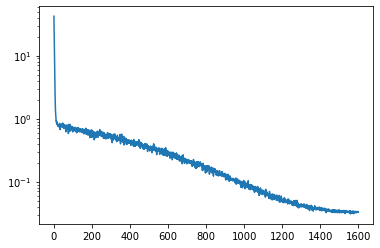

In [36]:
RM5.plot_loss()

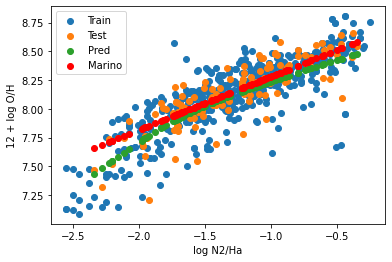

In [37]:
f, ax = plt.subplots()
ax.scatter(np.log10(RM5.X_train_unscaled), RM5.y_train, label='Train')
ax.scatter(np.log10(RM5.X_test_unscaled), RM5.y_test, label='Test')
ax.scatter(np.log10(RM5.X_test_unscaled), RM5.pred, label='Pred')
ax.scatter(np.log10(RM5.X_test_unscaled), ab_N2(np.log10(RM5.X_test_unscaled)), c=c_Marino, label='Marino')
ax.set_xlabel(diag)
ax.set_ylabel('12 + log O/H')
ax.legend();
#print(np.std(RM5.pred-RM5.y_test), np.std(ab_N2(np.log10(RM5.X_test_unscaled))- RM5.y_test))

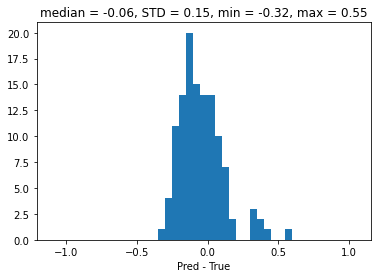

In [38]:
f, ax = plt.subplots()
dif = RM5.pred - RM5.y_test  
ax.hist(dif, bins=np.arange(-1.1, 1.1, .05))
ax.set_title('median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))
ax.set_xlabel('Pred - True');

### The same for O3N2

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 474, Test set size = 119
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 474, Test set size = 119
Training set size = 474, Test set size = 119
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 30)                60        
_________________________________________________________________
dense_25 (Dense)             (None, 20)                620       
_________________________________________________________________
dropout_12 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 21        
Total params: 701
Trainable params: 701
Non-trainable params:

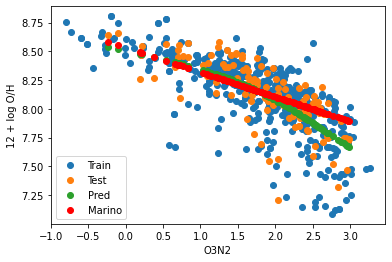

In [34]:
RM5b = ai4neb.manage_RM(RM_type='K_ANN',
                       X_train=t['O3N2'], 
                       y_train=t['Ab(O)'], 
                       scaling=True, 
                       use_log=True,
                       verbose=True, 
                       random_seed=random_seed,
                       split_ratio=0.2)
RM5b.init_RM(hidden_layer_sizes=(30,20), dropout=(0., 0.3),
           activation='tanh',
           solver='adam', 
           epochs=1600)
RM5b.train_RM()
RM5b.predict()
f, ax = plt.subplots()
ax.scatter(np.log10(RM5b.X_train_unscaled), RM5b.y_train, label='Train')
ax.scatter(np.log10(RM5b.X_test_unscaled), RM5b.y_test, label='Test')
ax.scatter(np.log10(RM5b.X_test_unscaled), RM5b.pred, label='Pred')
ax.scatter(np.log10(RM5b.X_test_unscaled), ab_O3N2(np.log10(RM5b.X_test_unscaled)), c=c_Marino, label='Marino')
ax.set_xlabel('O3N2')
ax.set_ylabel('12 + log O/H')
ax.legend();

## Combining the 3 strong lines used by Pilyugin

In [39]:
RM5c = ai4neb.manage_RM(RM_type='K_ANN',
                       X_train=np.array((t['R2+'], t['R3+'], t['N2+'])).T,
                       y_train=t['Ab(O)'], 
                       scaling=True, 
                       use_log=True,
                       verbose=True, 
                       random_seed=random_seed,
                       split_ratio=0.2)
RM5c.init_RM(hidden_layer_sizes=(30, 20), dropout=(0., 0.3),
           activation='tanh',
           solver='adam', 
           epochs=1000)
RM5c.train_RM()
RM5c.predict()

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 474, Test set size = 119
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 474, Test set size = 119
Training set size = 474, Test set size = 119
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 30)                120       
_________________________________________________________________
dense_31 (Dense)             (None, 20)                620       
_________________________________________________________________
dropout_14 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 21        
Total params: 761
Trainable params: 761
Non-trainable params

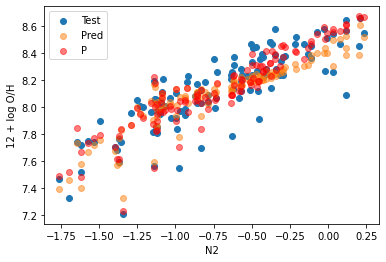

In [40]:
f, ax = plt.subplots()
R2 = RM5c.X_test_unscaled[:,0]
R3 = RM5c.X_test_unscaled[:,1]
N2 = RM5c.X_test_unscaled[:,2]
ax.scatter(np.log10(N2), RM5c.y_test, label='Test')
ax.scatter(np.log10(N2), RM5c.pred, label='Pred', alpha=0.5)
ax.scatter(np.log10(N2), ab_P16(R2, R3, N2), c=c_Marino, label='P', alpha=0.5)
ax.set_xlabel('N2')
ax.set_ylabel('12 + log O/H')
ax.legend();

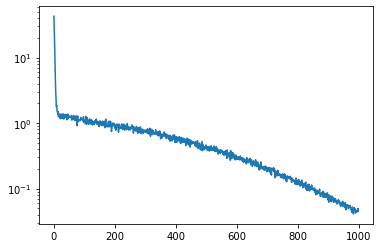

In [41]:
RM5c.plot_loss()

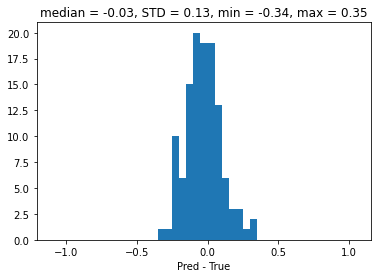

In [42]:
f, ax = plt.subplots()
dif = RM5c.pred - RM5c.y_test
ax.hist(dif, bins=np.arange(-1.1, 1.1, .05))
ax.set_title('median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))
ax.set_xlabel('Pred - True');

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 474, Test set size = 119
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 474, Test set size = 119
Training set size = 474, Test set size = 119
Regression Model SK_SVM
Training 3 inputs for 1 outputs with 474 data
RM trained. Score = 0.837
SVR()
Training time 0.0 s.
Predicting from 3 inputs to 1 outputs using 119 data in 0.00 secs.


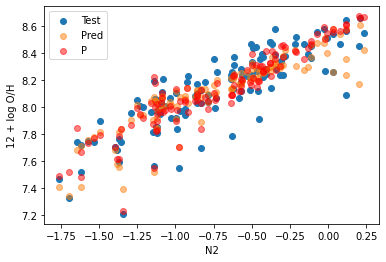

In [43]:
RM5d = ai4neb.manage_RM(RM_type='SK_SVM',
                       X_train=np.array((t['R2+'], t['R3+'], t['N2+'])).T,
                       y_train=t['Ab(O)'], 
                       scaling=True, 
                       use_log=True,
                       verbose=True, 
                       random_seed=random_seed,
                       split_ratio=0.2)
RM5d.init_RM()
RM5d.train_RM()
RM5d.predict()
f, ax = plt.subplots()
R2 = RM5d.X_test_unscaled[:,0]
R3 = RM5d.X_test_unscaled[:,1]
N2 = RM5d.X_test_unscaled[:,2]
ax.scatter(np.log10(N2), RM5d.y_test, label='Test')
ax.scatter(np.log10(N2), RM5d.pred, label='Pred', alpha=0.5)
ax.scatter(np.log10(N2), ab_P16(R2, R3, N2), c=c_Marino, label='P', alpha=0.5)
ax.set_xlabel('N2')
ax.set_ylabel('12 + log O/H')
ax.legend();

In [44]:
RM5e = ai4neb.manage_RM(RM_type='SK_BR',
                       X_train=np.array((t['R2+'], t['R3+'], t['N2+'])).T,
                       y_train=t['Ab(O)'], 
                       scaling=True, 
                       use_log=True,
                       verbose=True, 
                       random_seed=random_seed,
                       split_ratio=0.2)
RM5e.init_RM()
RM5e.train_RM()
RM5e.predict()

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 474, Test set size = 119
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 474, Test set size = 119
Training set size = 474, Test set size = 119
Regression Model SK_BR
Training 3 inputs for 1 outputs with 474 data
RM trained, with 3 iterations. Score = 0.714
BayesianRidge()
Training time 0.0 s.
Predicting from 3 inputs to 1 outputs using 119 data in 0.00 secs.


In [45]:
RM5f = ai4neb.manage_RM(RM_type='SK_GPR',
                       X_train=np.array((t['R2+'], t['R3+'], t['N2+'])).T,
                       y_train=t['Ab(O)'], 
                       scaling=True, 
                       use_log=True,
                       verbose=True, 
                       random_seed=random_seed,
                       split_ratio=0.2)
RM5f.init_RM()
RM5f.train_RM()
RM5f.predict()

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 474, Test set size = 119
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 474, Test set size = 119
Training set size = 474, Test set size = 119
Regression Model SK_GPR
Training 3 inputs for 1 outputs with 474 data
RM trained. Score = 0.948
GaussianProcessRegressor(random_state=10)
Training time 0.0 s.
Predicting from 3 inputs to 1 outputs using 119 data in 0.00 secs.


In [46]:
RM5g = ai4neb.manage_RM(RM_type='SK_SGDR',
                       X_train=np.array((t['R2+'], t['R3+'], t['N2+'])).T,
                       y_train=t['Ab(O)'], 
                       scaling=True, 
                       use_log=True,
                       verbose=True, 
                       random_seed=random_seed,
                       split_ratio=0.2)
RM5g.init_RM()
RM5g.train_RM()
RM5g.predict()

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 474, Test set size = 119
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 474, Test set size = 119
Training set size = 474, Test set size = 119
Regression Model SK_SGDR
Training 3 inputs for 1 outputs with 474 data
RM trained, with 12 iterations. Score = 0.705
SGDRegressor(random_state=10)
Training time 0.0 s.
Predicting from 3 inputs to 1 outputs using 119 data in 0.00 secs.


### Using the 4 strong lines used by Ho

In [47]:
X_train=np.array((t['O2'],
                 t['O3'],
                 t['N2'],
                 t['S2+'])).T
RM5z = ai4neb.manage_RM(RM_type='SK_SVM',
                       X_train=X_train,
                       y_train=t['Ab(O)'], 
                       scaling=True, 
                       use_log=True,
                       verbose=True, 
                       random_seed=random_seed,
                       split_ratio=0.2)
RM5z.init_RM()
RM5z.train_RM()
RM5z.predict()

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 474, Test set size = 119
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 470, Test set size = 119
Training set size = 470, Test set size = 119
Regression Model SK_SVM
Training 4 inputs for 1 outputs with 470 data
RM trained. Score = 0.867
SVR()
Training time 0.0 s.
Predicting from 4 inputs to 1 outputs using 119 data in 0.00 secs.


In [48]:
O2 = RM5z.X_test_unscaled[:,0]
O3 = RM5z.X_test_unscaled[:,1]
N2 = RM5z.X_test_unscaled[:,2]
S2p = RM5z.X_test_unscaled[:,3]

oxygenClass = OxygenMLP()
oxygenClass.ingestLines(O2,O3, N2, S2p)
z, z_err = oxygenClass.predictZ()

f, ax = plt.subplots()
ax.scatter(np.log10(N2), RM5z.y_test, label='Test')
ax.scatter(np.log10(N2), RM5z.pred, label='Pred', alpha=0.5)
ax.scatter(np.log10(N2), ab_P16(O2, O3*1.335, N2*1.34), c=c_Marino, label='P', alpha=0.5)
ax.scatter(np.log10(N2), z, label='Ho', alpha=0.5)

ax.set_xlabel('N2')
ax.set_ylabel('12 + log O/H')
ax.legend();

ModuleNotFoundError: No module named 'sklearn.preprocessing.data'

### Now we are training with 9 line ratios as inputs: O3N2, N2, R23, S2, P, etc.

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 474, Test set size = 119
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 470, Test set size = 119
Training set size = 470, Test set size = 119
Regression Model XGB
Training 9 inputs for 1 outputs with 470 data
RM trained. Score = 0.987
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=10,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Training

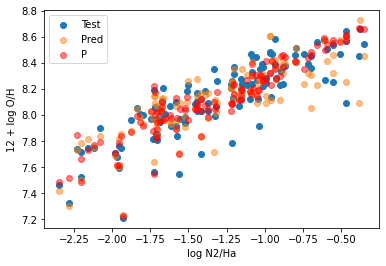

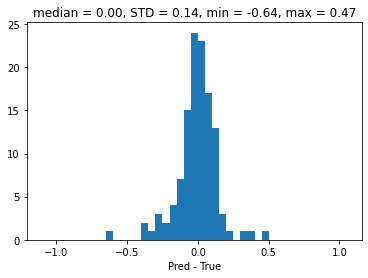

In [49]:
X_train=np.array((t['O3N2'],
                 t['N2/Ha'],
                 t['R2+'],
                 t['R3+'],
                 t['N2+']/t['R2+'],
                 t['R3+']/t['S2+'],
                 t['S2+'],
                 t['R23'],
                 t['P'])).T
RM6a = ai4neb.manage_RM(RM_type='XGB',
                       X_train=X_train,
                       y_train=t['Ab(O)'], 
                       scaling=True, 
                       use_log=True,
                       verbose=True, 
                       random_seed=random_seed,
                       split_ratio=0.2)
RM6a.init_RM()
RM6a.train_RM()
RM6a.predict()
f, ax = plt.subplots()
R2p = RM6a.X_test_unscaled[:,2]
R3p = RM6a.X_test_unscaled[:,3]
N2a = RM6a.X_test_unscaled[:,1]
N2 =  N2a * 2.85
N2p = N2 * 1.34
ax.scatter(np.log10(N2a), RM6a.y_test, label='Test')
ax.scatter(np.log10(N2a), RM6a.pred, label='Pred', alpha=0.5)
ax.scatter(np.log10(N2a), ab_P16(R2p, R3p, N2p), c=c_Marino, label='P', alpha=0.5)
ax.set_xlabel('log N2/Ha')
ax.set_ylabel('12 + log O/H')
ax.legend();
f, ax = plt.subplots()
dif = RM6a.pred - RM6a.y_test
ax.hist(dif, bins=np.arange(-1.1, 1.1, .05))
ax.set_title('median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))
ax.set_xlabel('Pred - True');

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 474, Test set size = 119
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 470, Test set size = 119
Training set size = 470, Test set size = 119
Regression Model SK_SVM
Training 9 inputs for 1 outputs with 470 data
RM trained. Score = 0.869
SVR()
Training time 0.0 s.
Predicting from 9 inputs to 1 outputs using 119 data in 0.00 secs.


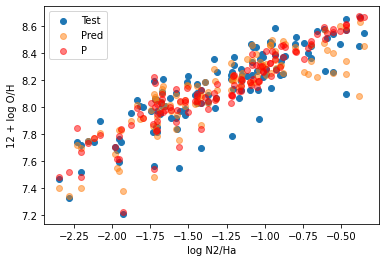

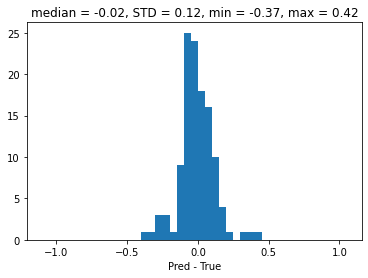

In [50]:
X_train=np.array((t['O3N2'],
                 t['N2/Ha'],
                 t['R2+'],
                 t['R3+'],
                 t['N2+']/t['R2+'],
                 t['R3+']/t['S2+'],
                 t['S2+'],
                 t['R23'],
                 t['P'])).T
RM6b = ai4neb.manage_RM(RM_type='SK_SVM',
                       X_train=X_train,
                       y_train=t['Ab(O)'], 
                       scaling=True, 
                       use_log=True,
                       verbose=True, 
                       random_seed=random_seed,
                       split_ratio=0.2)
RM6b.init_RM()
RM6b.train_RM()
RM6b.predict()
f, ax = plt.subplots()
R2p = RM6a.X_test_unscaled[:,2]
R3p = RM6a.X_test_unscaled[:,3]
N2a = RM6a.X_test_unscaled[:,1]
N2 =  N2a * 2.85
N2p = N2 * 1.34
ax.scatter(np.log10(N2a), RM6b.y_test, label='Test')
ax.scatter(np.log10(N2a), RM6b.pred, label='Pred', alpha=0.5)
ax.scatter(np.log10(N2a), ab_P16(R2p, R3p, N2p), c=c_Marino, label='P', alpha=0.5)
ax.set_xlabel('log N2/Ha')
ax.set_ylabel('12 + log O/H')
ax.legend();
f, ax = plt.subplots()
dif = RM6b.pred - RM6b.y_test
ax.hist(dif, bins=np.arange(-1.1, 1.1, .05))
ax.set_title('median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))
ax.set_xlabel('Pred - True');

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 474, Test set size = 119
Discretizing column 0 on 20 bins
Discretizing column 0 on 20 bins
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 470, Test set size = 119
Training set size = 470, Test set size = 119
Regression Model SK_ANN_Dis
Training 9 inputs for 20 outputs with 470 data
RM trained, with 41 iterations. Score = 0.100
MLPRegressor(random_state=10)
Training time 0.2 s.
Reducing y by max
Predicting from 9 inputs to 20 outputs using 119 data in 0.00 secs.


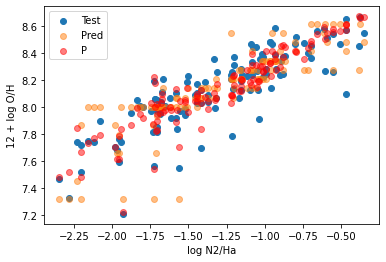

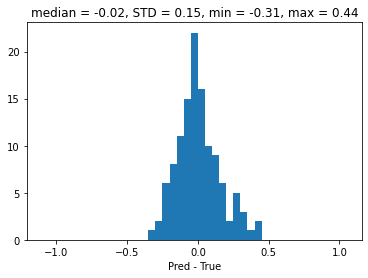

In [51]:
X_train=np.array((t['O3N2'],
                 t['N2/Ha'],
                 t['R2+'],
                 t['R3+'],
                 t['N2+']/t['R2+'],
                 t['R3+']/t['S2+'],
                 t['S2+'],
                 t['R23'],
                 t['P'])).T
RM6bd = ai4neb.manage_RM(RM_type='SK_ANN_Dis',
                         X_train=X_train,
                         y_train=t['Ab(O)'], 
                         scaling=True, 
                         use_log=True,
                         verbose=True, 
                         random_seed=random_seed,
                         split_ratio=0.2,
                         N_y_bins=20)
RM6bd.init_RM()
RM6bd.train_RM()
RM6bd.predict(reduce_by='max')
f, ax = plt.subplots()
R2p = RM6bd.X_test_unscaled[:,2]
R3p = RM6bd.X_test_unscaled[:,3]
N2a = RM6bd.X_test_unscaled[:,1]
N2 =  N2a * 2.85
N2p = N2 * 1.34
ax.scatter(np.log10(N2a), RM6bd.y_test_ori, label='Test')
ax.scatter(np.log10(N2a), RM6bd.pred, label='Pred', alpha=0.5)
ax.scatter(np.log10(N2a), ab_P16(R2p, R3p, N2p), c=c_Marino, label='P', alpha=0.5)
ax.set_xlabel('log N2/Ha')
ax.set_ylabel('12 + log O/H')
ax.legend();
f, ax = plt.subplots()
dif = RM6bd.pred - RM6bd.y_test_ori
ax.hist(dif, bins=np.arange(-1.1, 1.1, .05))
ax.set_title('median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))
ax.set_xlabel('Pred - True');

In [52]:
RM6 = ai4neb.manage_RM(RM_type='K_ANN',
                       X_train=np.array((t['O3N2'],
                                         t['N2/Ha'],
                                         t['R2+'],
                                         t['R3+'],
                                         t['N2+']/t['R2+'],
                                         t['R3+']/t['S2+'],
                                         t['S2+'],
                                         t['R23'],
                                         t['P'])).T, 
                       #X_train=np.array((t['O3']/t['Hb']/t['N2']*t['Ha'], t['N2']/t['Ha'])).T, 
                       y_train=t['Ab(O)'], 
                       scaling=True, 
                       use_log=True,
                       verbose=True, 
                       random_seed=random_seed,
                       split_ratio=0.2, 
                       clear_session=True)
RM6.init_RM(hidden_layer_sizes=(30, 20), 
           #tol=1e-8, 
           #max_iter=10000, 
           #activation='tanh',
           #solver='lbfgs'            
            dropout=(0.0, 0.3), 
            activation='tanh',
            solver='adam',
            epochs=1000
           )
RM6.train_RM()
RM6.predict()
RM6.save_RM('RMs/yOH-X9lines')

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 474, Test set size = 119
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 470, Test set size = 119
Training set size = 470, Test set size = 119
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                300       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 941
Trainable params: 941
Non-trainable params: 0

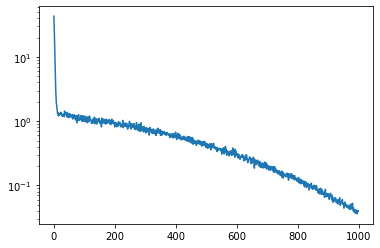

In [53]:
RM6.plot_loss()

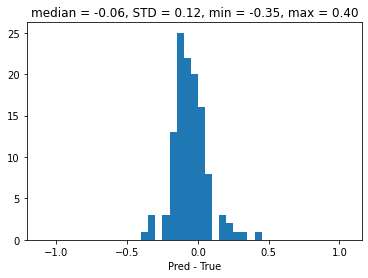

In [54]:
f, ax = plt.subplots()
dif = RM6.pred - RM6.y_test
ax.hist(dif, bins=np.arange(-1.1, 1.1, .05))
ax.set_title('median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))
ax.set_xlabel('Pred - True');

In [55]:
def plot_3(RM):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    if RM.N_in == 9:
        O3N2 = RM.X_test_unscaled[:,0][RM.isfin]
        R23 = RM.X_test_unscaled[:,7][RM.isfin]
        N2a = RM.X_test_unscaled[:,1][RM.isfin] 
        R3p = RM.X_test_unscaled[:,3][RM.isfin]
        R2p = RM.X_test_unscaled[:,2][RM.isfin] 
        N2 =  N2a * 2.85
        N2p = N2 * 1.34
    elif RM.N_in == 3:
        R2p = RM.X_test_unscaled[:,0][RM.isfin] 
        R3p = RM.X_test_unscaled[:,1][RM.isfin]
        N2p = RM.X_test_unscaled[:,2][RM.isfin]
        N2 = N2p / 1.34
        N2a = N2 / 2.85
        O3 = R3p / 1.335
        O3N2 = O3 / N2a
        R23 = R2p + R3p
    elif RM.N_in == 4:
        R2p = RM.X_test_unscaled[:,0][RM.isfin] 
        O3 = RM.X_test_unscaled[:,1][RM.isfin]
        N2 = RM.X_test_unscaled[:,2][RM.isfin]
        N2p = N2 * 1.34
        N2a = N2 / 2.85
        R3p = O3 * 1.335
        O3N2 = O3 / N2a
        R23 = R2p + R3p        
        
    ax1.scatter(np.log10(O3N2), RM.y_test_ori, label='Test')
    ax1.scatter(np.log10(O3N2), RM.pred, label='Pred')
    ax1.scatter(np.log10(O3N2), ab_O3N2(np.log10(O3N2)), c=c_Marino, label='Marino')
    ax1.scatter(np.log10(O3N2), ab_P16(R2p, R3p, N2p ), label='P', alpha=0.5)
    #for x, y1, y2 in zip(np.log10(RM6.X_test_unscaled)[:,0][RM6.isfin], RM6.y_test, RM6.pred):
    #    ax1.plot((x, x), (y1, y2), c='g')
    ax1.legend()
    ax1.set_xlabel('O3N2')

    ax2.scatter(np.log10(N2a), RM.y_test_ori, label='Test')
    ax2.scatter(np.log10(N2a), RM.pred, label='Pred')
    ax2.scatter(np.log10(N2a), ab_N2(np.log10(N2a)), 
                c=c_Marino, label='Marino')
    ax2.scatter(np.log10(N2a), ab_P16(R2p, R3p, N2p ), label='P', alpha=0.5)
    #for x, y1, y2 in zip(np.log10(RM6.X_test_unscaled)[:,1][RM6.isfin], RM6.y_test, RM6.pred):
    #    ax2.plot((x, x), (y1, y2), c='g')
    ax2.legend()
    ax2.set_xlabel('log N2/Ha');


    ax3.scatter(np.log10(R23), RM.y_test_ori, label='Test')
    ax3.scatter(np.log10(R23), RM.pred, label='Pred')
    ax3.scatter(np.log10(R23), ab_P16(R2p, R3p, N2p ), label='P', alpha=0.5)
    for x, y1, y2,y3 in zip(np.log10(R23), RM.y_test, RM.pred, ab_P16(R2p, R3p, N2p )):
        pass
        #ax3.plot((x, x), (y1, y2), c='g')
        #ax3.plot((x+0.02, x+0.02), (y1, y3), c='r')        
    ax3.legend()
    ax3.set_xlabel('R23');    

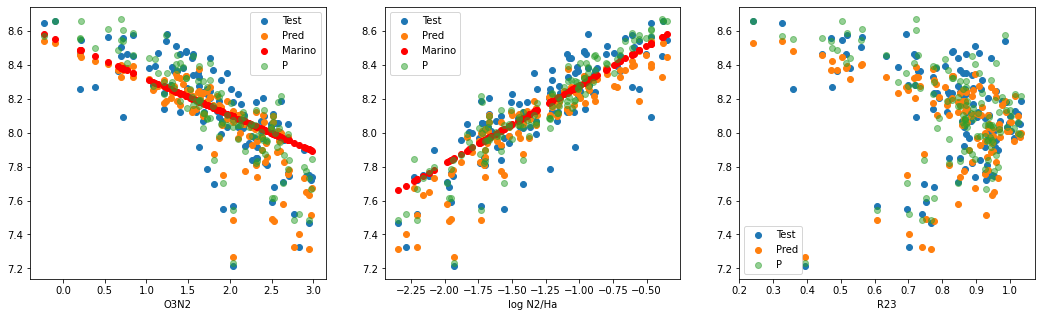

In [56]:
plot_3(RM6)

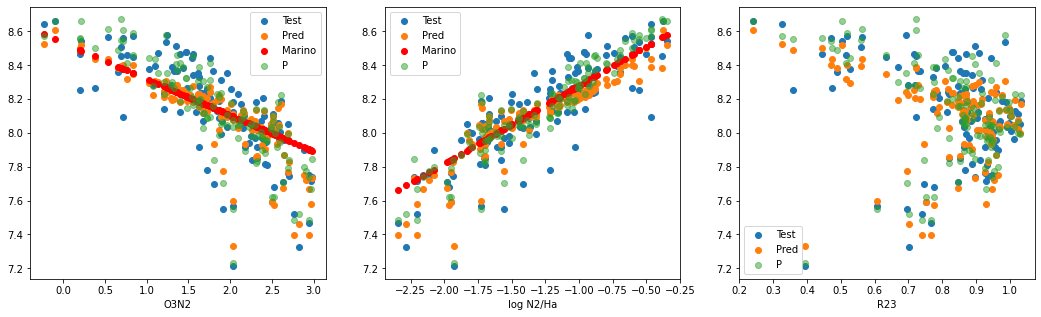

In [57]:
plot_3(RM5c)

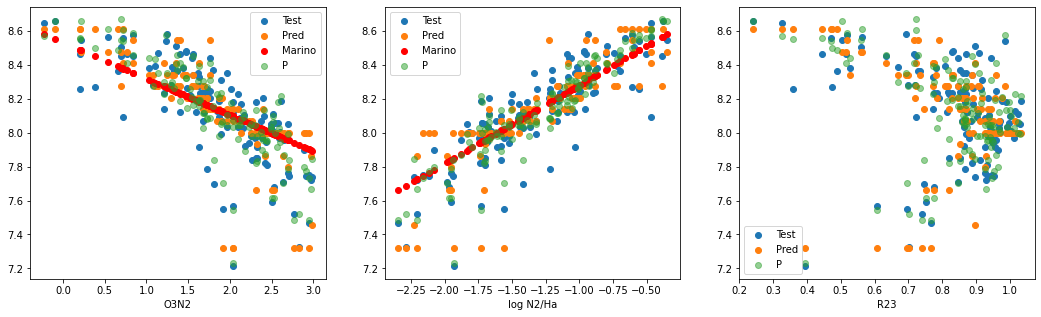

In [58]:
plot_3(RM6bd)

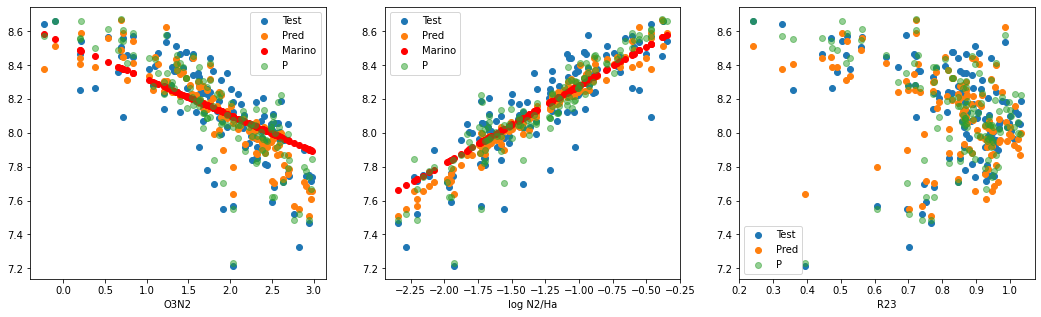

In [59]:
plot_3(RM5e)

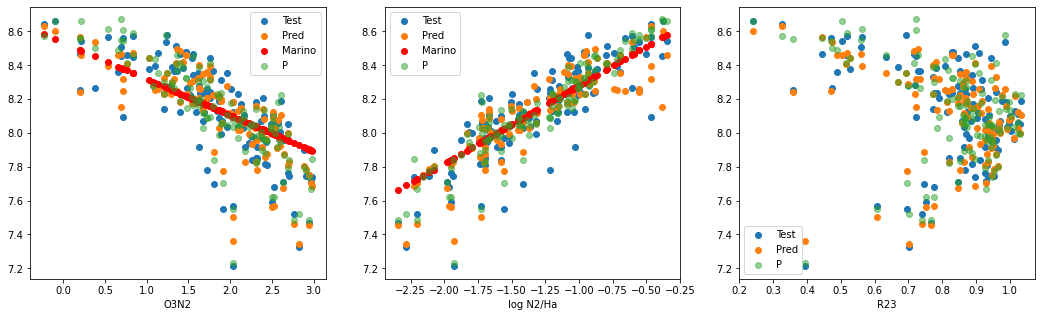

In [60]:
plot_3(RM5z)

#### Predictions have a scatter when seen in 1D only. These scatters reduce the discrepancies between predictions and true values.

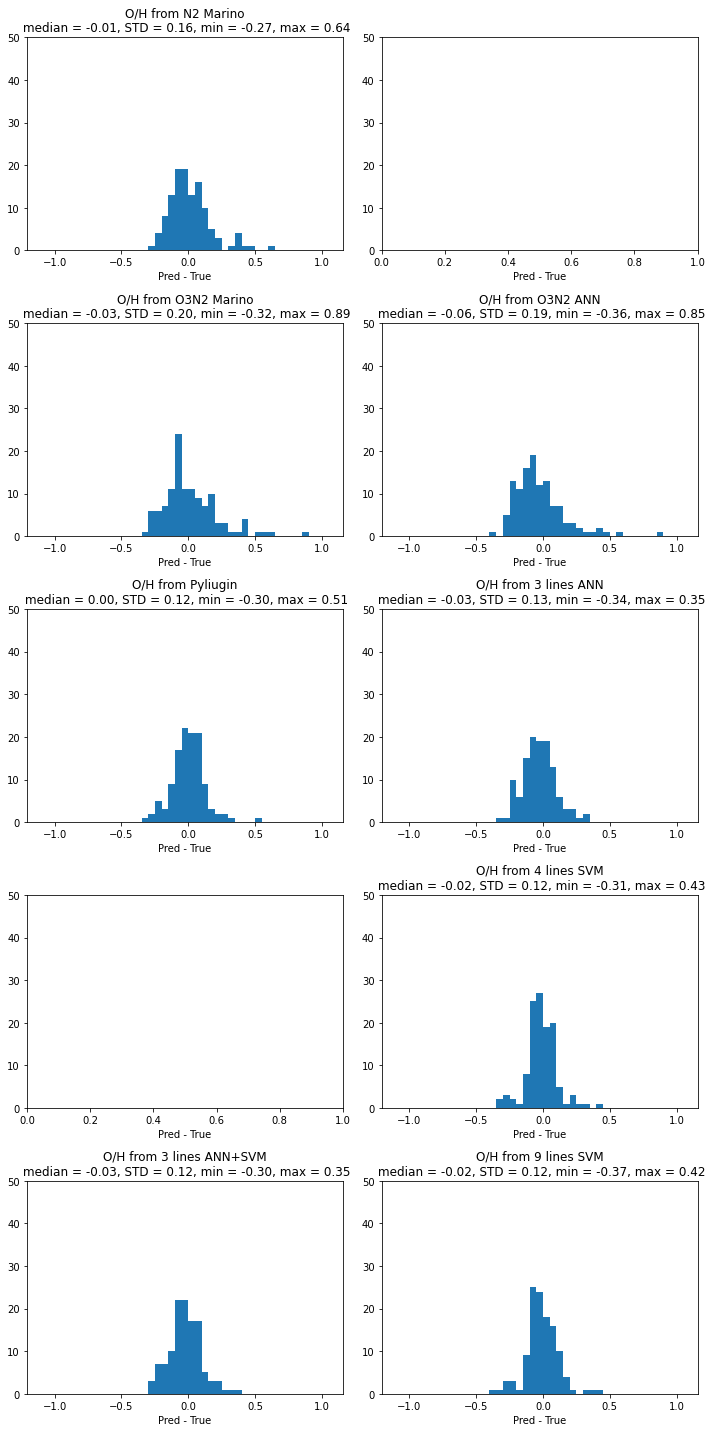

In [62]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(10, 20))

bins = np.arange(-1.1, 1.1, .05)
dif = ab_N2(np.log10(RM5.X_test_unscaled)) - RM5.y_test  
ax1.hist(dif, bins=bins)
ax1.set_title('O/H from N2 Marino\n median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))

"""
dif = RM5.pred - RM5.y_test 
ax2.hist(dif, bins=bins)
ax2.set_title('O/H from N2 ANN\n median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))
"""
dif = ab_O3N2(np.log10(RM5b.X_test_unscaled)) - RM5b.y_test  
ax3.hist(dif, bins=bins)
ax3.set_title('O/H from O3N2 Marino\n median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))

dif = RM5b.pred - RM5b.y_test 
ax4.hist(dif, bins=bins)
ax4.set_title('O/H from O3N2 ANN\n median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))

R2 = RM5c.X_test_unscaled[:,0]
R3 = RM5c.X_test_unscaled[:,1]
N2 = RM5c.X_test_unscaled[:,2]
dif = ab_P16(R2, R3, N2) - RM5c.y_test[:,0] 
ax5.hist(dif, bins=bins)
ax5.set_title('O/H from Pyliugin\n median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))

dif = RM5c.pred - RM5c.y_test 
ax6.hist(dif, bins=bins)
ax6.set_title('O/H from 3 lines ANN\n median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))

#dif = RM6.pred - RM6.y_test 
#ax7.hist(dif, bins=bins)
#ax7.set_title('O/H from 9 lines ANN\n median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))
"""
dif = z - RM5z.y_test[:,0] 
ax7.hist(dif, bins=bins)
ax7.set_title('O/H from 4 lines Ho\n median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))
"""
#dif = RM5d.pred - RM5d.y_test 
#ax7.hist(dif, bins=bins)
#ax7.set_title('O/H from 3 lines SVM\n median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))

dif = RM5z.pred - RM5z.y_test
ax8.hist(dif, bins=bins)
ax8.set_title('O/H from 4 lines SVM\n median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))

dif = RM5f.pred - RM5f.y_test 
dif = (RM5c.pred+RM5d.pred)/2 - RM5f.y_test 
ax9.hist(dif, bins=bins)
ax9.set_title('O/H from 3 lines ANN+SVM\n median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))

dif = RM6b.pred - RM6b.y_test 
ax10.hist(dif, bins=bins)
ax10.set_title('O/H from 9 lines SVM\n median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))


#dif = RM5g.pred - RM5g.y_test
#ax10.hist(dif, bins=bins)
#ax10.set_title('O/H from 3 lines SGDR\n median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))



for ax in (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10):
    ax.set_xlabel('Pred - True')
    ax.set_ylim((0, 50))
f.tight_layout()

In [63]:
#tralala

Instantiation. V 0.17
train and test sets are obtained by splitting X_train and y_train.
input test sets are not used.
Training set size = 474, Test set size = 119
Train data scaled. Log10 applied. 
Test data scaled. Log10 applied. 
Training set size = 474, Test set size = 119
Training set size = 474, Test set size = 119
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 30)                120       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 761
Trainable params: 761
Non-trainable params:

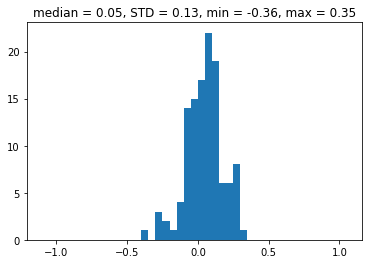

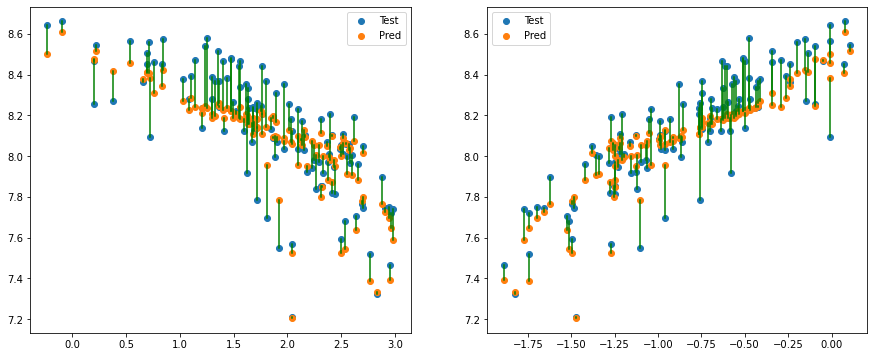

In [64]:
# With adamax
RM6x = ai4neb.manage_RM(RM_type='K_ANN',
                       X_train=np.array((t['O3N2'], t['N2'], t['R23'])).T, 
                       y_train=t['Ab(O)'], 
                       scaling=True, 
                       use_log=True,
                       verbose=True, 
                       random_seed=random_seed,
                       split_ratio=0.2)
RM6x.init_RM(hidden_layer_sizes=(30,20), dropout=(0.0, 0.3), 
           activation='tanh',
           solver='adamax',epochs=1500)
RM6x.train_RM()
RM6x.predict()
f, ax = plt.subplots()
dif = RM6x.y_test - RM6x.pred
print(RM6x.y_test.shape, RM6x.pred.shape)
ax.hist(dif, bins=np.arange(-1.1, 1.1, .05))
ax.set_title('median = {:.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.scatter(np.log10(RM6x.X_test_unscaled)[:,0][RM6x.isfin], RM6x.y_test, label='Test')
ax1.scatter(np.log10(RM6x.X_test_unscaled)[:,0][RM6x.isfin], RM6x.pred, label='Pred')
for x, y1, y2 in zip(np.log10(RM6x.X_test_unscaled)[:,0][RM6x.isfin], RM6x.y_test, RM6x.pred):
    ax1.plot((x, x), (y1, y2), c='g')
ax1.legend()

ax2.scatter(np.log10(RM6x.X_test_unscaled)[:,1][RM6x.isfin], RM6x.y_test, label='Test')
ax2.scatter(np.log10(RM6x.X_test_unscaled)[:,1][RM6x.isfin], RM6x.pred, label='Pred')
for x, y1, y2 in zip(np.log10(RM6x.X_test_unscaled)[:,1][RM6x.isfin], RM6x.y_test, RM6x.pred):
    ax2.plot((x, x), (y1, y2), c='g')
ax2.legend();

### We can explore the effect of changing the random seed

In [55]:
np.seterr(divide='ignore')
for r_seed in 4 + np.arange(5):
    RM7 = ai4neb.manage_RM(RM_type='K_ANN',
                          X_train=t['N2'], 
                          y_train=t['Ab(O)'], 
                          scaling=True, 
                          use_log=True,
                          verbose=False, 
                          random_seed=r_seed,
                          split_ratio=0.3)
    RM7.init_RM(hidden_layer_sizes=(30,20), dropout=(0.0, 0.3), 
                activation='tanh',
                solver='adam', 
                epochs=1500)
    RM7.train_RM()
    RM7.predict() 
    dif7 = RM7.y_test - RM7.pred
      
    RM8 = ai4neb.manage_RM(RM_type='K_ANN',
                      X_train=np.array((t['O3N2'], t['N2'], t['R23'])).T,
                      y_train=t['Ab(O)'], 
                      scaling=True, 
                      use_log=True,
                      verbose=False, 
                      random_seed=r_seed,
                      split_ratio=0.3)
    RM8.init_RM(hidden_layer_sizes=(30,20), dropout=(0.0, 0.3), 
               activation='tanh',
               solver='adam', 
               epochs=1500)
    RM8.train_RM()
    RM8.predict()
    dif8 = RM8.y_test - RM8.pred
    print('median = {:5.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f} || median = {:5.2f}, STD = {:.2f}, min = {:.2f}, max = {:.2f}'.format(np.median(dif7), np.std(dif7), np.min(dif7), np.max(dif7), np.median(dif8), np.std(dif8), np.min(dif8), np.max(dif8)))

median =  0.02, STD = 0.18, min = -0.78, max = 0.66 || median =  0.01, STD = 0.15, min = -0.74, max = 0.50
median =  0.01, STD = 0.17, min = -0.67, max = 0.47 || median = -0.00, STD = 0.14, min = -0.66, max = 0.41
median =  0.04, STD = 0.16, min = -0.56, max = 0.67 || median =  0.01, STD = 0.12, min = -0.31, max = 0.53
median =  0.04, STD = 0.20, min = -0.80, max = 0.49 || median =  0.03, STD = 0.16, min = -0.74, max = 0.44
median =  0.02, STD = 0.18, min = -0.78, max = 0.35 || median =  0.01, STD = 0.15, min = -0.75, max = 0.37


In [56]:
# Generate error to stop notebook here
print(tralala)

### Test reading a model saved before

In [57]:
RM = ai4neb.manage_RM(RM_filename='yOH-XO3N2_N2_R23_P')
RM.verbose = True

No ai4neb file found for yOH-XO3N2_N2_R23_P


### Download some theoretical values from 3MdB

In [58]:
sel = """SELECT
O__3__5007A/N__2__6584A as O3N2,  
N__2__6584A/H__1__4861A as N2, 
(O__3__5007A+TOTL__3727A)/H__1__4861A as R23, 
O__3__5007A / (O__3__5007A+TOTL__3727A) as P,
(S_II__6716A+S_II__6731A)/H__1__4861A as S2,
12+OXYGEN as O
FROM tab 
WHERE ref = 'BOND' AND OXYGEN > -4.76 AND OXYGEN < -3.24"""
db = pymysql.connect(host=os.environ['MdB_HOST'], 
                        user=os.environ['MdB_USER'], 
                        passwd=os.environ['MdB_PASSWD'], 
                        db=os.environ['MdB_DBp'])    
res = pd.read_sql(sel, con=db)
db.close()

In [59]:
RM.set_test(np.array(res[['O3N2', 'N2', 'R23', 'P']]))
RM.predict()
RM.pred.shape

Exception: WARNING: Regression Model not set up

In [ ]:
f, ax  = plt.subplots()
ax.scatter(res['O'], RM.pred[:,0] - res['O'], alpha=0.01)
ax.set_xlabel('12 + log(O/H)')
ax.set_ylabel('Pred - True');

In [ ]:
f, ax  = plt.subplots()
dif = (RM.pred[:,0] - res['O'])
ax.hist(dif, bins=50)
ax.set_xlabel('Pred - True')
ax.set_title('Median: {:.2f} STD: {:.2f} min: {:.2f} max: {:.2f}'.format(np.median(dif), np.std(dif), np.min(dif), np.max(dif)));

In [ ]:
RM6rec = ai4neb.manage_RM(RM_filename='yOH-X9lines')

In [ ]:
RM6rec.set_test(RM6.X_test_unscaled)

In [ ]:
RM6rec.predict()

In [ ]:
np.sqrt(((RM6rec.pred - RM6.pred)**2).sum())